# MLP time series predictions
MLP method more or less using this method as a source https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

tldr: Transform dataset into supervised method, make it stationary, transform to scale, MLP

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as tqdm_general
import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


Converting series to supervised and scaling functions.

In [2]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(-i) for i in range(0, lag)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# speshul scaling
def scale2(train_data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_data)
    # transform train
    train = train_data.reshape(train_data.shape[0], train_data.shape[1])
    train_scaled = scaler.transform(train_data)
    return scaler, train_scaled

def fit_existing_scaler(train_data, scaler):
    train_scaled = scaler.transform(train_data)
    return train_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

Single model per category approach

In [3]:
def create_model(window_length):
    model = Sequential()
    model.add(Dense(window_length, activation='relu', input_shape=(window_length,)))
    model.add(Dense(200))
    model.add(Dense(200))
    model.add(Dense(100))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')    
    return model

def fit_model(model, train, batch_size, nb_epoch):
    X, y = train[:, 0:-1], train[:, -1]    
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)

def generate_new_window(train_scaled, predictions_scaled, window_length, index):
    # sufficient number of predictions exist
    if index - window_length >= 0:
        new_train = predictions_scaled[-window_length:]
        return np.asarray(new_train).reshape((1, window_length))
    
    # insufficient predictions, use some from last train sequence
    else:
        train_end = train_scaled[0][-(window_length - index):]
        new_train = np.concatenate((train_end, predictions_scaled))
        return new_train.reshape((1, window_length))
    
def make_window_predictions(model, train_scaled, scaler, raw_values, number_of_predictions, window_length):
    scaled_predictions = list()
    predictions = list()
    
    X_train = train_scaled[-1, -window_length:].reshape((1, window_length))    
    yhat = model.predict(X_train, 1)[0, 0]
    scaled_predictions.append(yhat)

    yhat = invert_scale(scaler, X_train[0], yhat)
    yhat = yhat + raw_values[-1]
    predictions.append(yhat)
    
    # Predict N steps into the FUTURE!
    for i in range(1, number_of_predictions):
        X = generate_new_window(X_train, scaled_predictions, window_length, i)
        
        yhat = model.predict(X, 1)[0, 0]
        scaled_predictions.append(yhat)
        
        yhat = invert_scale(scaler, X[0], yhat)
        yhat = yhat + predictions[-1]
        predictions.append(yhat)   
    return predictions

# Create sliding window dataset
def create_dataset(train_series, window_length):
    windowed_set = timeseries_to_supervised(train_series, window_length)
    windowed_set = windowed_set.iloc[:-window_length]
    return windowed_set

# predicts from single time series using categorical model
def predict_from_model(train_series, model, scaler, n_predictions=1, window_length=5, batch_size=4, nb_epoch=5):
    supervised_values = timeseries_to_supervised(train_series, window_length)
    supervised_values = supervised_values.iloc[:-window_length].values
    
    train_scaled = fit_existing_scaler(supervised_values, scaler)
    return make_window_predictions(model, train_scaled, scaler, train_series, n_predictions, window_length)
    
# fits or predicts, returns either predictions or nothing respectively
def fit_full_category(train_series, model, window_length=5, batch_size=4, nb_epoch=5):
    scaler, train_scaled = scale2(train_series.values)
    fit_model(model, train_scaled, batch_size, nb_epoch)
    return scaler

Prerequisite dataframes, dictionaries, and lists for training and predicting processes. 

In [4]:
# Prediction lengths for different scopes
horizon_lengths = {"H" : 48, "D" : 14, "W" : 13, "M" : 18, "Q" : 8, "Y" : 6}
window_lengths = {"H" : 96, "D" : 28, "W" : 26, "M" : 36, "Q" : 16, "Y" : 12}

# Scope + category as key for models, i.e daily_finance or w/e
datasets = {}
models = {}
scalers = {}

# All filenames for different scopes
filenames = os.listdir("./data/cut/10000/train/")
#filenames = ["Hourly.csv"]

# Results
results_frame = pd.DataFrame()

# Test series frame for plotting or w/e
test_frame = pd.DataFrame()

# M4 info for information about categories
m4_info = pd.read_csv('./data/M4-info.csv')

### Create windowed dataframes per category

In [5]:
for file in filenames:
    train_set = pd.read_csv('./data/cut/10000/train/' + file)
        
    # Go through all the time series in the scope 
    for i in tnrange(1, train_set.shape[0], desc=file):
        current_series = train_set.iloc[i, 2:].dropna()
        series_name = train_set.iloc[i, 1]
        series_info = m4_info.loc[m4_info['M4id'] == series_name]
            
        category_name = series_info['category'].values[0].lower()
        scope_name = series_info['SP'].values[0].lower()
        model_key = scope_name + "_" + category_name
            
        n_window = window_lengths[series_name[0].upper()]
        
        if model_key in datasets:
            current_dataset = create_dataset(current_series, n_window)
            np_combined_data = np.concatenate([datasets[model_key], current_dataset], axis=0)
            datasets[model_key] = pd.DataFrame(np_combined_data)
        else:
            datasets[model_key] = create_dataset(current_series, n_window)

### Loopy training

In [6]:
t = tqdm(datasets.items(), desc="Training")
for model_key, dataset in t:
    t.set_description(model_key)
    t.refresh() 
    
    n_window = window_lengths[model_key[0].upper()]
    
    if model_key in models:
        current_model = models[model_key]
    else:
        current_model = create_model(window_length=n_window)
        models[model_key] = current_model
    
    model_category_series = datasets[model_key]
    scaler = fit_full_category(model_category_series, current_model, window_length=n_window, batch_size=16, nb_epoch=20)
    
    scalers[model_key] = scaler
    models[model_key] = current_model
    #assert False

### Write models and scalers to files
NB! set the batch identificator to whatever is going on at the moment.

In [7]:
model_batch_identificator = '150518/'
models_folder = './models/' + model_batch_identificator
scalers_folder = './scalers/' + model_batch_identificator

if not os.path.exists(models_folder):
    os.makedirs(models_folder)

for model_callsign, model in models.items():
    model.save(models_folder + model_callsign + '.h5')
    
if not os.path.exists(scalers_folder):
    os.makedirs(scalers_folder)

for scaler_callsign, scaler in scalers.items():
    joblib.dump(scaler, scalers_folder + scaler_callsign + '.pkl') 

### SANITY IS FOR THE WEAK! (Read models and scalers from files)
NB! set the batch identificator to whatever is going on at the moment.

In [8]:
model_batch_identificator = '150518/'

models_folder = './models/' + model_batch_identificator
scalers_folder = './scalers/' + model_batch_identificator

model_filenames = os.listdir(models_folder)
scaler_filenames = os.listdir(scalers_folder)

# create a models dict if it doesn't exist and create other required data objects 
if 'models' not in globals() and 'scalers' not in globals():
    models = {}
    scalers = {}
    horizon_lengths = {"H" : 48, "D" : 14, "W" : 13, "M" : 18, "Q" : 8, "Y" : 6}
    window_lengths = {"H" : 96, "D" : 28, "W" : 26, "M" : 36, "Q" : 16, "Y" : 12}

    filenames = os.listdir("./data/cut/10000/train/")
    #filenames = ["Hourly.csv"]
    m4_info = pd.read_csv('./data/M4-info.csv')

    results_frame = pd.DataFrame()
    test_frame = pd.DataFrame()

    for model_file in model_filenames:
        models[model_file.split(".")[0]] = load_model(models_folder + model_file)
    
    for scaler_file in scaler_filenames:
        scalers[scaler_file.split(".")[0]] = joblib.load(scalers_folder + scaler_file) 

### Loopy predictions

In [9]:
for file in filenames:
    train_set = pd.read_csv('./data/cut/10000/train/' + file)
    test_set = pd.read_csv('./data/cut/10000/test/' + file)
    
    # Go through all the time series in the scope 
    for i in tnrange(1, train_set.shape[0], desc=file):
        series_name = train_set.iloc[i, 1]
        series_info = m4_info.loc[m4_info['M4id'] == series_name]
        
        category_name = series_info['category'].values[0].lower()
        scope_name = series_info['SP'].values[0].lower()
        model_key = scope_name + "_" + category_name 
        
        model = models[model_key]
        scaler = scalers[model_key]
        
        n_predictions = horizon_lengths[series_name[0].upper()]
        n_window = window_lengths[series_name[0].upper()]
        
        series = train_set.iloc[i, 2:].dropna()
        test_series = test_set.iloc[i, 1:].tolist()
        test_series.insert(0, series_name)
        
        pred = predict_from_model(series, model, scaler, n_predictions, window_length=n_window)
        pred.insert(0, series_name)
        
        results_frame = results_frame.append(pd.Series(pred), ignore_index=True)
        test_frame = test_frame.append(pd.Series(test_series), ignore_index=True)   
        #assert False
    #assert False

Write separate results into .csv files.

In [10]:
hourly_frame = results_frame[results_frame[0].str.contains("H")] 
hourly_frame = hourly_frame.dropna(axis=1, how='all')
hourly_frame.to_csv("./results/h_results.csv", index=False)

daily_frame = results_frame[results_frame[0].str.contains("D")]
daily_frame = daily_frame.dropna(axis=1, how='all')
daily_frame.to_csv("./results/d_results.csv", index=False)

weekly_frame = results_frame[results_frame[0].str.contains("W")]
weekly_frame = weekly_frame.dropna(axis=1, how='all')
weekly_frame.to_csv("./results/w_results.csv", index=False)

monthly_frame = results_frame[results_frame[0].str.contains("M")]
monthly_frame = monthly_frame.dropna(axis=1, how='all')
monthly_frame.to_csv("./results/m_results.csv", index=False)

quarterly_frame = results_frame[results_frame[0].str.contains("Q")]
quarterly_frame = quarterly_frame.dropna(axis=1, how='all')
quarterly_frame.to_csv("./results/q_results.csv", index=False)

yearly_frame = results_frame[results_frame[0].str.contains("Y")]
yearly_frame = yearly_frame.dropna(axis=1, how='all')
yearly_frame.to_csv("./results/y_results.csv", index=False)

Write all the resulting data frame to .csv.

In [11]:
results_frame.to_csv("./results/all_results_seq.csv", index=False)

Printing out a single prediction, if one so chooses

Test RMSE: 17821.572


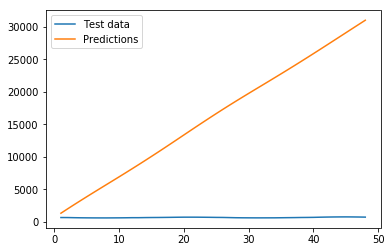

In [12]:
rmse = np.sqrt(mean_squared_error(test_frame.iloc[0, 1:], results_frame.iloc[0, 1:]))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test_frame.iloc[0, 1:], label="Test data")
plt.plot(results_frame.iloc[0, 1:], label="Predictions")
plt.legend()
plt.show()